# Анализ ридов

Считаем GC состав для ридов, фильтруем их по качеству, изучаем зависимость качества нуклеотида от позиции в риде

In [16]:
from Bio import SeqIO
from Bio import SeqUtils

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")
sns.set_style("dark")

In [3]:
def calculate_gc_sum_and_len(record):
    """Remove Q<=25 nucleotides and count GC and length without N"""
    seq = [record.seq[i] for i in range(len(record.seq)) if record.letter_annotations["phred_quality"][i] > 25]
    seq = "".join(seq).replace("N", "")
    g = seq.count("G")
    c = seq.count("C")
    return g + c, len(seq)

In [4]:
from tqdm import tqdm
import gzip
import math

In [5]:
percents_to_frequenicies = {}
for i in range(100 + 1):
    percents_to_frequenicies[i] = 0

# Parse FASTQ, increase frequency of each GC we meet
with gzip.open("/home/prep/NGS/data/1/100x.1.fastq.gz", "rt") as f: 
    for i, record in tqdm(enumerate(SeqIO.parse(f, format="fastq"))):
        gc_sum_short, short_len = calculate_gc_sum_and_len(record)
        if short_len == 0:
            continue
        gc = round(gc_sum_short / short_len * 100)
        percents_to_frequenicies[gc] += 1
  
x1 = list(percents_to_frequenicies.keys())
y1 = list(percents_to_frequenicies.values())

2500000it [05:14, 7943.97it/s]


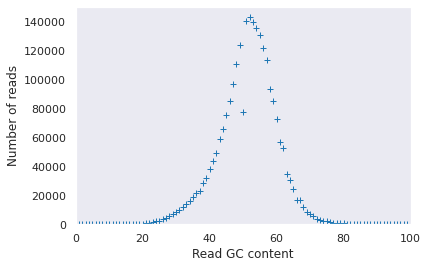

In [11]:
plt.plot(x1, y1, '+')
plt.xlim(0, 100)
plt.ylim(0, 150000)

plt.xlabel("Read GC content")
plt.ylabel("Number of reads")
plt.show()

In [12]:
positions_to_average_errors = {}
for i in range(100 + 1):
    positions_to_average_errors[i] = 0

# Parse FASTQ, calculate average quality based on known previous one 
# for every position in 100 length short read
with gzip.open("/home/prep/NGS/data/1/100x.1.fastq.gz", "rt") as f: 
    for i, record in tqdm(enumerate(SeqIO.parse(f, format="fastq"))):
        quality = record.letter_annotations["phred_quality"]
        for j, pos_qual in enumerate(quality):
            sum_for_j = positions_to_average_errors[j]*i
            positions_to_average_errors[j] = (sum_for_j + pos_qual) / (i+1)

# Average quality to average error (p = 10^(-q / 10))
for pos, value in positions_to_average_errors.items():
    positions_to_average_errors[pos] = 10**(-value / 10)
    
x2 = list(positions_to_average_errors.keys())
y2 = list(positions_to_average_errors.values())

2500000it [02:51, 14568.56it/s]


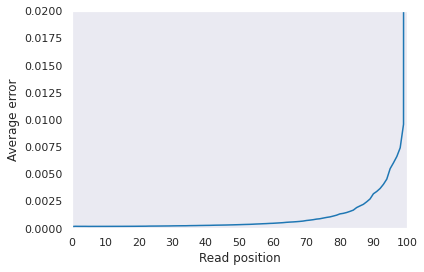

In [15]:
plt.plot(x2, y2)
plt.xlim([0, 100])
plt.xticks([i*10 for i in range(10+1)])
plt.ylim([0, 0.02])
plt.xlabel("Read position")
plt.ylabel("Average error")
plt.show()

FASTQC results

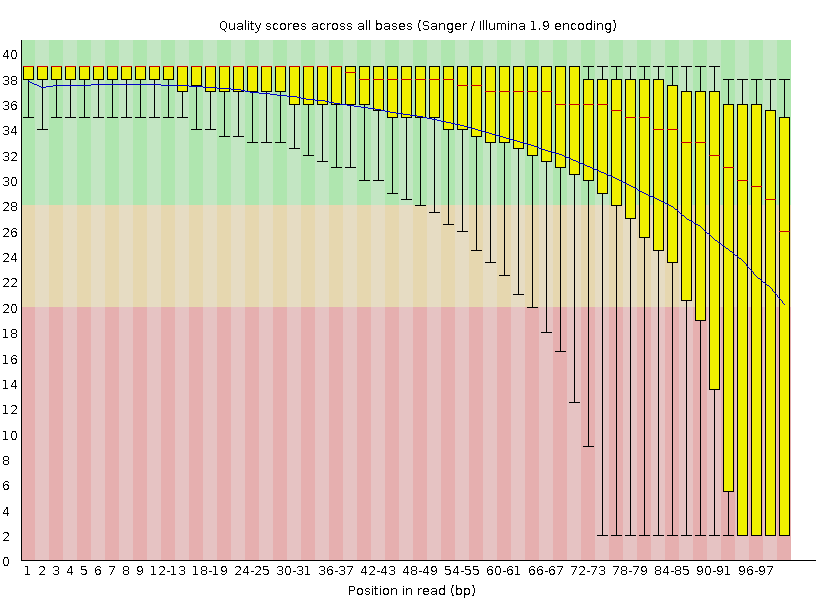

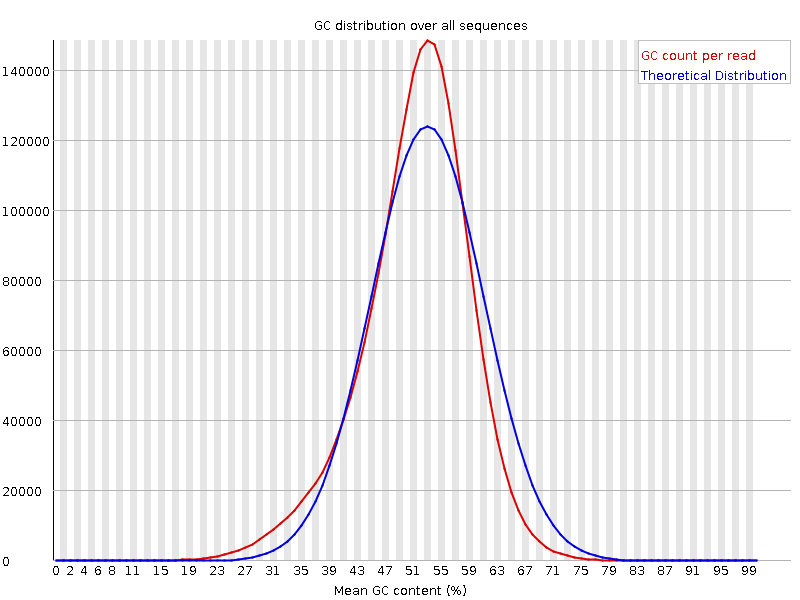